# 프로젝트: CutMix 또는 Mixup 비교실험 하기

지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 보았습니다.

이번에는 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜 봅시다. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜 주세요. 결과를 수치화하고 비교하는 것도 잊지마세요!

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

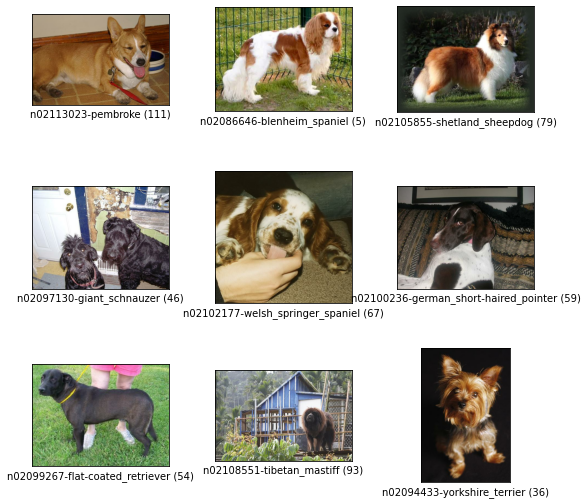

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

## 1. Augmentation을 적용한 데이터셋 만들기

이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용



* 첫번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수를  구현

* 바탕이미지 a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현

In [4]:

def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

In [5]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three], axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

* 라벨섞기

In [6]:
# mix two labels
def mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa) * (yb-ya)
    total_area = image_size_x * image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

* 배치단위의 cutmix

In [7]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [8]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

* mixup 사용

* 배치단위의 mixup 

In [9]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [10]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

def onehot(image, label, num_classes=120):
    label = tf.one_hot(label, num_classes)
    return image, label

In [11]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 데이터 불러오기

In [12]:
num_classes = ds_info.features["label"].num_classes

In [40]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

## 2. 모델 만들기, 훈련

In [14]:
# 기본
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [17]:
EPOCH = 20
tf.random.set_seed(1000)

In [18]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


In [20]:
hist_resnet50 = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 115s 153ms/step - loss: 2.1896 - accuracy: 0.4542 - val_loss: 3.3173 - val_accuracy: 0.2178
Epoch 2/20
750/750 [==============================] - 115s 154ms/step - loss: 0.7818 - accuracy: 0.7804 - val_loss: 1.3906 - val_accuracy: 0.6076
Epoch 3/20
750/750 [==============================] - 116s 154ms/step - loss: 0.3077 - accuracy: 0.9262 - val_loss: 0.9661 - val_accuracy: 0.7222
Epoch 4/20
750/750 [==============================] - 116s 154ms/step - loss: 0.1169 - accuracy: 0.9820 - val_loss: 0.9737 - val_accuracy: 0.7221
Epoch 5/20
750/750 [==============================] - 116s 155ms/step - loss: 0.0532 - accuracy: 0.9954 - val_loss: 0.9201 - val_accuracy: 0.7411
Epoch 6/20
750/750 [==============================] - 116s 155ms/step - loss: 0.0306 - accuracy: 0.9972 - val_loss: 0.9274 - val_accuracy: 0.7407
Epoch 7/20
750/750 [==============================] - 116s 155ms/step - loss: 0.0210 - accuracy: 0.9976 - val_loss: 1.0187 -

In [41]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [42]:
hist_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 115s 153ms/step - loss: 2.2005 - accuracy: 0.4504 - val_loss: 3.8419 - val_accuracy: 0.1437
Epoch 2/20
750/750 [==============================] - 115s 154ms/step - loss: 0.8938 - accuracy: 0.7418 - val_loss: 1.0670 - val_accuracy: 0.6909
Epoch 3/20
750/750 [==============================] - 116s 154ms/step - loss: 0.4912 - accuracy: 0.8613 - val_loss: 1.1696 - val_accuracy: 0.6649
Epoch 4/20
750/750 [==============================] - 116s 154ms/step - loss: 0.2507 - accuracy: 0.9390 - val_loss: 1.0153 - val_accuracy: 0.7098
Epoch 5/20
750/750 [==============================] - 116s 155ms/step - loss: 0.1424 - accuracy: 0.9712 - val_loss: 1.1738 - val_accuracy: 0.6861
Epoch 6/20
750/750 [==============================] - 116s 155ms/step - loss: 0.0717 - accuracy: 0.9899 - val_loss: 0.9556 - val_accuracy: 0.7341
Epoch 7/20
750/750 [==============================] - 116s 155ms/step - loss: 0.0355 - accuracy: 0.9962 - val_loss: 0.9204 -

In [22]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [24]:
hist_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 117s 156ms/step - loss: 3.8564 - accuracy: 0.2066 - val_loss: 3.5720 - val_accuracy: 0.1765
Epoch 2/20
750/750 [==============================] - 118s 157ms/step - loss: 2.9565 - accuracy: 0.4237 - val_loss: 1.2841 - val_accuracy: 0.6396
Epoch 3/20
750/750 [==============================] - 118s 158ms/step - loss: 2.6461 - accuracy: 0.5303 - val_loss: 1.3819 - val_accuracy: 0.6131
Epoch 4/20
750/750 [==============================] - 118s 158ms/step - loss: 2.4512 - accuracy: 0.5928 - val_loss: 1.2181 - val_accuracy: 0.6632
Epoch 5/20
750/750 [==============================] - 119s 158ms/step - loss: 2.2758 - accuracy: 0.6452 - val_loss: 1.3655 - val_accuracy: 0.6360
Epoch 6/20
750/750 [==============================] - 119s 158ms/step - loss: 2.1614 - accuracy: 0.6850 - val_loss: 1.1592 - val_accuracy: 0.6763
Epoch 7/20
750/750 [==============================] - 119s 158ms/step - loss: 2.0897 - accuracy: 0.7044 - val_loss: 1.1494 -

In [25]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [26]:

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 119s 159ms/step - loss: 3.7222 - accuracy: 0.2407 - val_loss: 3.6855 - val_accuracy: 0.1630
Epoch 2/20
750/750 [==============================] - 119s 159ms/step - loss: 2.8763 - accuracy: 0.4728 - val_loss: 1.5455 - val_accuracy: 0.5698
Epoch 3/20
750/750 [==============================] - 120s 160ms/step - loss: 2.5933 - accuracy: 0.5857 - val_loss: 1.2751 - val_accuracy: 0.6346
Epoch 4/20
750/750 [==============================] - 120s 160ms/step - loss: 2.4091 - accuracy: 0.6426 - val_loss: 1.4548 - val_accuracy: 0.5969
Epoch 5/20
750/750 [==============================] - 120s 160ms/step - loss: 2.2588 - accuracy: 0.7089 - val_loss: 1.2185 - val_accuracy: 0.6630
Epoch 6/20
750/750 [==============================] - 116s 154ms/step - loss: 2.1501 - accuracy: 0.7469 - val_loss: 1.3389 - val_accuracy: 0.6329
Epoch 7/20
750/750 [==============================] - 119s 158ms/step - loss: 2.0669 - accuracy: 0.7775 - val_loss: 1.3721 -

## 3. 훈련과정 시각화

* acc

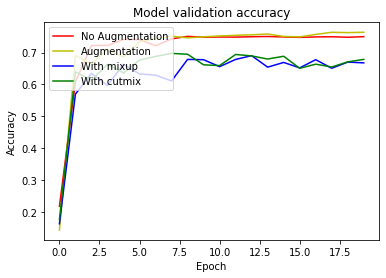

In [43]:
plt.plot(hist_resnet50.history['val_accuracy'], 'r')
plt.plot(hist_resnet50_aug.history['val_accuracy'], 'y')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'b')
plt.plot(hist_resnet50_cutmix.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'With mixup', 'With cutmix'], loc='upper left')
plt.show()

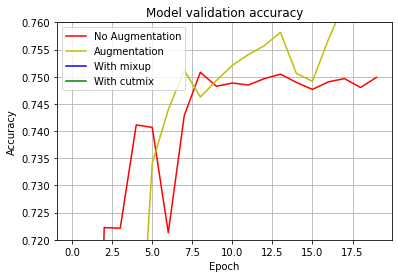

In [44]:
plt.plot(hist_resnet50.history['val_accuracy'], 'r')
plt.plot(hist_resnet50_aug.history['val_accuracy'], 'y')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'b')
plt.plot(hist_resnet50_cutmix.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'With mixup', 'With cutmix'], loc='upper left')
plt.grid()
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

* loss

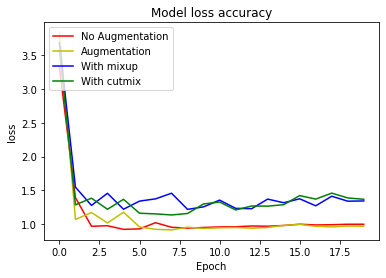

In [45]:
plt.plot(hist_resnet50.history['val_loss'], 'r')
plt.plot(hist_resnet50_aug.history['val_loss'], 'y')
plt.plot(history_resnet50_mixup.history['val_loss'], 'b')
plt.plot(hist_resnet50_cutmix.history['val_loss'], 'g')
plt.title('Model loss accuracy')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','With mixup', 'With cutmix'], loc='upper left')
plt.show()

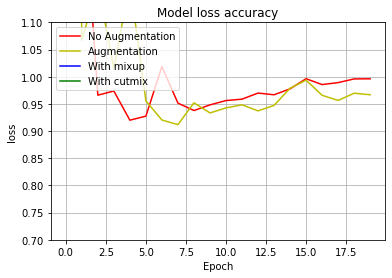

In [49]:
plt.plot(hist_resnet50.history['val_loss'], 'r')
plt.plot(hist_resnet50_aug.history['val_loss'], 'y')
plt.plot(history_resnet50_mixup.history['val_loss'], 'b')
plt.plot(hist_resnet50_cutmix.history['val_loss'], 'g')
plt.title('Model loss accuracy')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','With mixup', 'With cutmix'], loc='upper left')
plt.grid()
plt.ylim(0.7,1.1)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

In [ ]:
여러 기법을 사용한 것보다 간단하게 aug만 해준 결과가 더 좋게 나왔다, 모델이 섞이거나 혼합된 데이터를 잘 인식 못하는 것 같이 보인다.